# Imports and constants

In [99]:
%load_ext autoreload
%autoreload 2

import glob
import os

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from infernal import InfernalParser

from dammit.fileio.base import EmptyFile
import predictorthologs_utils as po
 
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys

In [3]:
sys.path

['/home/olga/code/tabula-microcebus--olgabot/rerun-utar-jan2021/notebooks',
 '/home/olga/anaconda/envs/tabula-microcebus-jan2021/lib/python37.zip',
 '/home/olga/anaconda/envs/tabula-microcebus-jan2021/lib/python3.7',
 '/home/olga/anaconda/envs/tabula-microcebus-jan2021/lib/python3.7/lib-dynload',
 '',
 '/home/olga/anaconda/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages',
 '/home/olga/anaconda/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/IPython/extensions',
 '/home/olga/.ipython']

## `def describe`

In [4]:
def describe(df, random=False):
    print(df.shape)
    print("--- First 5 entries ---")
    display(df.head())
    if random:
        print('--- Random subset ---')
        display(df.sample(5))

## predictorthologs output dir

In [5]:
predictorthologs_outdir = '/mnt/data_lg/olga/data_sm_copy/tabula-microcebus/analyses/predictorthologs/utar--july2021'

# Read data

## Utar dataframe

In [33]:
utar_df = pd.read_csv('/home/olga/data_lg/data_sm_copy/tabula-microcebus/analyses/de-novo-orthology/uTAR/free_anno_v1_diffMarkers_p0.05_uTAR_labeled.txt', sep='\t')
utar_df['utar_id'] = utar_df['fastaPeak'].str.replace(':', '--').str.lower()
# utar_df.columns = utar_df.columns.str.replace(' ', "_")
print(utar_df.shape)
utar_df.head()

(4005, 18)


,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,uTAR,chr,start,end,dir,fasta,blast,blastShort,X1,X2,fastaPeak,utar_id
0,7.966428e-72,0.731785,0.566,0.042,2.389594e-66,Bladder__artery cell,NC-033670.1-76132099-76134299---605-0,NC_033670.1,76132099,76134299,-,NC_033670.1:76132099-76134299,PREDICTED: Propithecus coquereli Rap guanine n...,GEF,709,940,NC_033670.1:76132808-76133039,nc_033670.1--76132808-76133039
1,2.574749e-34,0.556426,0.340,0.031,7.723165e-29,Bladder__artery cell,NC-033692.1-65380149-65381599-+-4534-0,NC_033692.1,65380149,65381599,+,NC_033692.1:65380149-65381599,PREDICTED: Microcebus murinus protein FAM127A-...,LOC105867558,871,1049,NC_033692.1:65381020-65381198,nc_033692.1--65381020-65381198
2,1.454604e-19,0.555519,0.302,0.044,4.363201e-14,Bladder__artery cell,NC-033690.1-27027849-27031249-+-235-0,NC_033690.1,27027849,27031249,+,NC_033690.1:27027849-27031249,Pan troglodytes chromosome 22 clone:RP43-117B1...,undetermined,1126,1479,NC_033690.1:27028975-27029328,nc_033690.1--27028975-27029328
3,7.318885e-17,0.821911,0.642,0.223,2.195358e-11,Bladder__artery cell,NC-033669.1-16534649-16536349-+-29034-0,NC_033669.1,16534649,16536349,+,NC_033669.1:16534649-16536349,PREDICTED: Microcebus murinus thioredoxin inte...,TXNIP,1258,1461,NC_033669.1:16535907-16536110,nc_033669.1--16535907-16536110
4,1.304279e-13,0.822385,0.906,0.806,3.912290e-08,Bladder__artery cell,NC-033667.1-8465249-8468099---12575-0,NC_033667.1,8465249,8468099,-,NC_033667.1:8465249-8468099,"Homo sapiens BAC clone RP11-690I21 from 2, com...",PTMA,27,323,NC_033667.1:8465276-8465572,nc_033667.1--8465276-8465572


## Read rfam2go

In [7]:
rfam2go = po.get_rfam2go_df()
describe(rfam2go)

/home/olga/code/tabula-microcebus--olgabot/rerun-utar-jan2021/notebooks/predictorthologs_utils.py:32: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  rfam2go_original = pd.read_csv(url, header=None, sep=" > ")


(3767, 4)
--- First 5 entries ---


,rfam_id_full,rfam_description,go_description,go_id
rfam_id,,,,
RF00001,Rfam:RF00001,5S_rRNA,GO:structural constituent of ribosome,GO:0003735
RF00001,Rfam:RF00001,5S_rRNA,GO:ribosome,GO:0005840
RF00002,Rfam:RF00002,5_8S_rRNA,GO:structural constituent of ribosome,GO:0003735
RF00002,Rfam:RF00002,5_8S_rRNA,GO:ribosome,GO:0005840
RF00003,Rfam:RF00003,U1,GO:mRNA 5'-splice site recognition,GO:0000395


## Read DIAMOND Blastp output

In [8]:
blastp_dir = os.path.join(predictorthologs_outdir, "blastp")
! ls -lha $blastp_dir | head 

total 119M
drwxr-xr-x  2 olga czb 1.0M Jul 18 13:22 .
drwxr-xr-x 12 olga czb 4.0K Jul 18 17:28 ..
-rw-r--r--  1 olga czb  560 Jul 18 12:38 nc_033660.1--100214049-100214149__molecule-protein_ksize-8__diamond__vertebrate_mammalian_concatenated__np_only_db.tsv
-rw-r--r--  1 olga czb  707 Jul 18 12:38 nc_033660.1--100390799-100394649__molecule-protein_ksize-8__diamond__vertebrate_mammalian_concatenated__np_only_db.tsv
-rw-r--r--  1 olga czb 1.3K Jul 18 12:38 nc_033660.1--100427399-100428099__molecule-protein_ksize-8__diamond__vertebrate_mammalian_concatenated__np_only_db.tsv
-rw-r--r--  1 olga czb  164 Jul 18 12:38 nc_033660.1--100839949-100841299__molecule-protein_ksize-8__diamond__vertebrate_mammalian_concatenated__np_only_db.tsv
-rw-r--r--  1 olga czb  555 Jul 18 12:38 nc_033660.1--101997299-101998899__molecule-protein_ksize-8__diamond__vertebrate_mammalian_concatenated__np_only_db.tsv
-rw-r--r--  1 olga czb    0 Jul 18 12:38 nc_033660.1--102218349-102219099__molecule-protein_ksize-8__d

In [9]:
filenames = glob.iglob(os.path.join(blastp_dir, "*.tsv"))

dfs = []


# Hard coded number of unique utars
total = 3931
n = 0

for filename in tqdm(filenames, total=total):
    filesize = os.path.getsize(filename)
    if filesize > 0:
        n += 1
        basename = os.path.basename(filename)
        split = basename.split("__molecule-")
        utar_id = split[0]
        #         utar_id = split[1]

        df = po.read_diamond_blastp_output(filename)
        df["utar_id"] = utar_id
        dfs.append(df)

utar_blastp = pd.concat(dfs)
print(utar_blastp.shape)
utar_blastp.head()

4003it [00:36, 109.33it/s]                          


(228245, 17)


,read_id,subject_id,percent_identity,e_value,bitscore,subject_title,subject_taxid,subject_species,subject_kingdom,subject_superkingdom,subject_phylum,description_with_status,additional_status,description,description_no_isoform,is_uncharacterized,utar_id
0,A00111:192:HFVL5DMXX:1:2335:32560:30013,NP_001357675.1,80.0,5.900000e-06,48.5,NP_001357675.1 protein angel homolog 1 isoform...,9606.0,Homo sapiens,Eukaryota,Chordata,NaN,protein angel homolog 1 isoform 1 precursor,NaN,protein angel homolog 1 isoform 1 precursor,protein angel homolog 1,False,nc_033689.1--8114449-8116699
1,A00111:192:HFVL5DMXX:1:2335:32560:30013,NP_001357677.1,80.0,5.900000e-06,48.5,NP_001357677.1 protein angel homolog 1 isoform...,9606.0,Homo sapiens,Eukaryota,Chordata,NaN,protein angel homolog 1 isoform 3 precursor,NaN,protein angel homolog 1 isoform 3 precursor,protein angel homolog 1,False,nc_033689.1--8114449-8116699
2,A00111:211:HGKCVDMXX:2:1364:9381:16454,NP_001357675.1,80.0,4.100000e-07,52.4,NP_001357675.1 protein angel homolog 1 isoform...,9606.0,Homo sapiens,Eukaryota,Chordata,NaN,protein angel homolog 1 isoform 1 precursor,NaN,protein angel homolog 1 isoform 1 precursor,protein angel homolog 1,False,nc_033689.1--8114449-8116699
3,A00111:211:HGKCVDMXX:2:1364:9381:16454,NP_001357677.1,80.0,4.100000e-07,52.4,NP_001357677.1 protein angel homolog 1 isoform...,9606.0,Homo sapiens,Eukaryota,Chordata,NaN,protein angel homolog 1 isoform 3 precursor,NaN,protein angel homolog 1 isoform 3 precursor,protein angel homolog 1,False,nc_033689.1--8114449-8116699
4,A00111:211:HGKCVDMXX:2:1364:9381:16454,NP_001265850.1,88.9,2.700000e-06,49.7,NP_001265850.1 cytochrome P450 3A43 isoform 4 ...,9606.0,Homo sapiens,Eukaryota,Chordata,NaN,cytochrome P450 3A43 isoform 4,NaN,cytochrome P450 3A43 isoform 4,cytochrome P450 3A43,False,nc_033689.1--8114449-8116699


In [10]:
utar_protein_hits = (
    utar_blastp.groupby("utar_id")
    .apply(lambda x: x.description_no_isoform.value_counts().head())
    .reset_index()
)
utar_protein_hits = utar_protein_hits.rename(columns={'level_1': 'description_no_isoform', 'description_no_isoform': 'n_hits'})
utar_protein_hits = utar_protein_hits.sort_values(['utar_id', 'n_hits'], ascending=False)
utar_protein_hits = utar_protein_hits.set_index(['utar_id', 'description_no_isoform'])
describe(utar_protein_hits)


(13364, 1)
--- First 5 entries ---


n_hits
utar_id                   description_no_isoform                                    
nw_017969113.1--2149-3199 40S ribosomal protein S3                               825
nw_017968608.1--2349-3349 chymotrypsin-like elastase family member 3B pre...     172
                          proproteinase E precursor                              123
                          uncharacterized protein LOC242711 precursor             47
                          chymotrypsin-like elastase family member 3B pre...      31

In [11]:
utar_protein_hits.head(20)

n_hits
utar_id                       description_no_isoform                                    
nw_017969113.1--2149-3199     40S ribosomal protein S3                               825
nw_017968608.1--2349-3349     chymotrypsin-like elastase family member 3B pre...     172
                              proproteinase E precursor                              123
                              uncharacterized protein LOC242711 precursor             47
                              chymotrypsin-like elastase family member 3B pre...      31
nw_017968535.1--91599-103100  zinc finger protein 28                                   7
                              D-aminoacyl-tRNA deacylase 1                             6
                              tRNA-splicing endonuclease subunit Sen2                  5
                              high mobility group protein HMGI-C                       5
nw_017968534.1--64399-67999   40S ribosomal protein S15a                               6
                              olfactory receptor 1F12                                  1
nw_017968532.1--143449-146599 malignant T-cell-amplified sequence 1                   88
                              plakophilin-2                                            7
                              serine/threonine-protein kinase Nek4                     3
                              uncharacterized protein LOC515358                        2
                              signal-transducing adaptor protein 2                     1
nw_017968532.1--117299-125549 WD repeat-containing and planar cell polarity e...       1
nw_017968532.1--117249-127599 WD repeat-containing and planar cell polarity e...       1
nw_017968525.1--625349-627899 protein angel homolog 1                                 16
                              serine/threonine-protein kinase Nek4                    12

## Infernal results

In [12]:
infernal_results_folder = os.path.join(predictorthologs_outdir, 'infernal')

In [13]:

dfs = []

for filename in tqdm(glob.glob(f'{infernal_results_folder}/*.txt')):
    try:
        df = pd.concat(InfernalParser(filename))
        basename = os.path.basename(filename)
        region_id = basename.split('__molecule-')[0]
        df['utar_id'] = region_id.lower()
        dfs.append(df)
    except EmptyFile:
        continue

infernal_results_original = pd.concat(dfs)
print(infernal_results_original.shape)
infernal_results_original.head()

100%|██████████| 4003/4003 [00:08<00:00, 445.25it/s]


(15630, 28)


,idx,target_name,target_accession,query_name,query_accession,clan_name,mdl,mdl_from,mdl_to,seq_from,...,inc,olp,anyidx,afrct1,afrct2,winidx,wfrct1,wfrct2,description,utar_id
0,1,DLEU2_5,RF02109,A00111:212:HGMF5DMXX:1:2167:28691:11788,<NA>,<NA>,cm,6,84,11,...,!,*,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Deleted in lymphocytic leukemia 2 conserved re...,nc_033672.1--63925749-63926749
0,1,7SK,RF00100,A00111:192:HFVL5DMXX:1:2150:3125:6370,<NA>,CL00013,cm,215,303,0,...,!,*,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,7SK RNA,nc_033665.1--60574249-60575149
1,1,7SK,RF00100,A00111:192:HFVL5DMXX:1:2419:18430:30405,<NA>,CL00013,cm,137,221,0,...,!,*,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,7SK RNA,nc_033665.1--60574249-60575149
2,1,7SK,RF00100,A00111:192:HFVL5DMXX:1:2202:16947:32878,<NA>,CL00013,cm,0,181,0,...,!,*,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,7SK RNA,nc_033665.1--60574249-60575149
3,1,7SK,RF00100,A00111:192:HFVL5DMXX:1:2202:16947:32878,<NA>,CL00013,cm,0,181,0,...,!,*,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,7SK RNA,nc_033665.1--60574249-60575149


In [14]:
infernal_results_original.e_value.describe()

count    1.563000e+04
mean     6.573363e-07
std      9.291448e-06
min      1.700000e-32
25%      3.925000e-19
50%      1.700000e-15
75%      1.500000e-11
max      2.600000e-04
Name: e_value, dtype: float64

In [15]:
utars_with_noncoding = set(infernal_results_original.utar_id)

## Venn diagram of coding vs noncoding

In [16]:
from matplotlib_venn import venn2

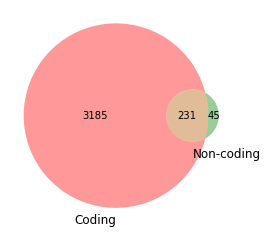

In [100]:
fig, ax = plt.subplots()
coding_set = set(utar_blastp.utar_id)
noncoding_set = set(infernal_results_original.utar_id)
venn2([coding_set, noncoding_set], set_labels=['Coding', 'Non-coding'])
fig.savefig('/home/olga/googledrive/TabulaMicrocebus/analysis/utar-predictorthologs/july2021_utar_coding_noncoding_venn_diagram_overlap.pdf')

In [18]:
utars_with_hits = noncoding_set.union(coding_set)
len(utars_with_hits)

3461

In [19]:
3262

3262

In [20]:
len(noncoding_set)

276

In [21]:
100 * len(noncoding_set)/utar_df.utar_id.nunique()

6.894828878341244

In [22]:
100 * len(utars_with_hits)/utar_df.utar_id.nunique()

86.46015488383712

In [23]:
utar_df.utar_id.nunique()

4003

# Merge UTAR info with blastp and noncoding results

In [24]:
infernal_results_metadata = infernal_results_original.merge(utar_df, on="utar_id")
infernal_results_metadata['hittype'] = 'Non-coding'
describe(infernal_results_metadata)

(0, 46)
--- First 5 entries ---


,idx,target_name,target_accession,query_name,query_accession,clan_name,mdl,mdl_from,mdl_to,seq_from,...,start,end,dir,fasta,blast,blastShort,X1,X2,fastaPeak,hittype


In [25]:
infernal_renamer = {
    "target_name": "subject_title",
    "target_accession": "subject_id",
    "query_name": "read_id",
}
infernal_cols = [
    "target_name",
    "target_accession",
    "clan_name",
    "description",
    "utar_id",
    "query_name",
]

infernal_results_column_subset = infernal_results_original[infernal_cols].rename(
    columns=infernal_renamer
)
infernal_results_column_subset['hittype'] = 'Non-coding'
describe(infernal_results_column_subset)

(15630, 7)
--- First 5 entries ---


,subject_title,subject_id,clan_name,description,utar_id,read_id,hittype
0,DLEU2_5,RF02109,<NA>,Deleted in lymphocytic leukemia 2 conserved re...,nc_033672.1--63925749-63926749,A00111:212:HGMF5DMXX:1:2167:28691:11788,Non-coding
0,7SK,RF00100,CL00013,7SK RNA,nc_033665.1--60574249-60575149,A00111:192:HFVL5DMXX:1:2150:3125:6370,Non-coding
1,7SK,RF00100,CL00013,7SK RNA,nc_033665.1--60574249-60575149,A00111:192:HFVL5DMXX:1:2419:18430:30405,Non-coding
2,7SK,RF00100,CL00013,7SK RNA,nc_033665.1--60574249-60575149,A00111:192:HFVL5DMXX:1:2202:16947:32878,Non-coding
3,7SK,RF00100,CL00013,7SK RNA,nc_033665.1--60574249-60575149,A00111:192:HFVL5DMXX:1:2202:16947:32878,Non-coding


## Subset blastp columns

In [26]:
utar_blastp.head()

,read_id,subject_id,percent_identity,e_value,bitscore,subject_title,subject_taxid,subject_species,subject_kingdom,subject_superkingdom,subject_phylum,description_with_status,additional_status,description,description_no_isoform,is_uncharacterized,utar_id
0,A00111:192:HFVL5DMXX:1:2335:32560:30013,NP_001357675.1,80.0,5.900000e-06,48.5,NP_001357675.1 protein angel homolog 1 isoform...,9606.0,Homo sapiens,Eukaryota,Chordata,NaN,protein angel homolog 1 isoform 1 precursor,NaN,protein angel homolog 1 isoform 1 precursor,protein angel homolog 1,False,nc_033689.1--8114449-8116699
1,A00111:192:HFVL5DMXX:1:2335:32560:30013,NP_001357677.1,80.0,5.900000e-06,48.5,NP_001357677.1 protein angel homolog 1 isoform...,9606.0,Homo sapiens,Eukaryota,Chordata,NaN,protein angel homolog 1 isoform 3 precursor,NaN,protein angel homolog 1 isoform 3 precursor,protein angel homolog 1,False,nc_033689.1--8114449-8116699
2,A00111:211:HGKCVDMXX:2:1364:9381:16454,NP_001357675.1,80.0,4.100000e-07,52.4,NP_001357675.1 protein angel homolog 1 isoform...,9606.0,Homo sapiens,Eukaryota,Chordata,NaN,protein angel homolog 1 isoform 1 precursor,NaN,protein angel homolog 1 isoform 1 precursor,protein angel homolog 1,False,nc_033689.1--8114449-8116699
3,A00111:211:HGKCVDMXX:2:1364:9381:16454,NP_001357677.1,80.0,4.100000e-07,52.4,NP_001357677.1 protein angel homolog 1 isoform...,9606.0,Homo sapiens,Eukaryota,Chordata,NaN,protein angel homolog 1 isoform 3 precursor,NaN,protein angel homolog 1 isoform 3 precursor,protein angel homolog 1,False,nc_033689.1--8114449-8116699
4,A00111:211:HGKCVDMXX:2:1364:9381:16454,NP_001265850.1,88.9,2.700000e-06,49.7,NP_001265850.1 cytochrome P450 3A43 isoform 4 ...,9606.0,Homo sapiens,Eukaryota,Chordata,NaN,cytochrome P450 3A43 isoform 4,NaN,cytochrome P450 3A43 isoform 4,cytochrome P450 3A43,False,nc_033689.1--8114449-8116699


In [27]:
blastp_cols = [
    "read_id",
    "subject_id",
    "subject_title",
    "description_no_isoform",
    "utar_id",
    "subject_species",
]
blastp_renamer = {
    "description_no_isoform": "description",
    "subject_species": "clan_name",
}

blastp_results_column_subset = utar_blastp[blastp_cols].rename(columns=blastp_renamer)
blastp_results_column_subset["hittype"] = "Coding"
describe(blastp_results_column_subset)

(228245, 7)
--- First 5 entries ---


,read_id,subject_id,subject_title,description,utar_id,clan_name,hittype
0,A00111:192:HFVL5DMXX:1:2335:32560:30013,NP_001357675.1,NP_001357675.1 protein angel homolog 1 isoform...,protein angel homolog 1,nc_033689.1--8114449-8116699,Homo sapiens,Coding
1,A00111:192:HFVL5DMXX:1:2335:32560:30013,NP_001357677.1,NP_001357677.1 protein angel homolog 1 isoform...,protein angel homolog 1,nc_033689.1--8114449-8116699,Homo sapiens,Coding
2,A00111:211:HGKCVDMXX:2:1364:9381:16454,NP_001357675.1,NP_001357675.1 protein angel homolog 1 isoform...,protein angel homolog 1,nc_033689.1--8114449-8116699,Homo sapiens,Coding
3,A00111:211:HGKCVDMXX:2:1364:9381:16454,NP_001357677.1,NP_001357677.1 protein angel homolog 1 isoform...,protein angel homolog 1,nc_033689.1--8114449-8116699,Homo sapiens,Coding
4,A00111:211:HGKCVDMXX:2:1364:9381:16454,NP_001265850.1,NP_001265850.1 cytochrome P450 3A43 isoform 4 ...,cytochrome P450 3A43,nc_033689.1--8114449-8116699,Homo sapiens,Coding


## Concatenate DIAMOND blastp (coding) and infernal cmscan (noncoding) results

In [28]:
coding_and_noncoding_results = pd.concat([infernal_results_column_subset, blastp_results_column_subset], ignore_index=True)
describe(coding_and_noncoding_results)

(243875, 7)
--- First 5 entries ---


,subject_title,subject_id,clan_name,description,utar_id,read_id,hittype
0,DLEU2_5,RF02109,<NA>,Deleted in lymphocytic leukemia 2 conserved re...,nc_033672.1--63925749-63926749,A00111:212:HGMF5DMXX:1:2167:28691:11788,Non-coding
1,7SK,RF00100,CL00013,7SK RNA,nc_033665.1--60574249-60575149,A00111:192:HFVL5DMXX:1:2150:3125:6370,Non-coding
2,7SK,RF00100,CL00013,7SK RNA,nc_033665.1--60574249-60575149,A00111:192:HFVL5DMXX:1:2419:18430:30405,Non-coding
3,7SK,RF00100,CL00013,7SK RNA,nc_033665.1--60574249-60575149,A00111:192:HFVL5DMXX:1:2202:16947:32878,Non-coding
4,7SK,RF00100,CL00013,7SK RNA,nc_033665.1--60574249-60575149,A00111:192:HFVL5DMXX:1:2202:16947:32878,Non-coding


In [91]:
coding_and_noncoding_results.groupby(['description']).utar_id.nunique().sort_values(ascending=False)

description
protein angel homolog 1                                     1492
zinc finger protein 28                                      1448
cytochrome P450 3A43                                        1441
D-aminoacyl-tRNA deacylase 1                                1226
signal-transducing adaptor protein 2                        1070
                                                            ... 
minor histocompatibility antigen H13                           1
microtubule-associated tumor suppressor 1                      1
microtubule-associated serine/threonine-protein kinase 4       1
microtubule-associated serine/threonine-protein kinase 3       1
1,2-dihydroxy-3-keto-5-methylthiopentene dioxygenase           1
Name: utar_id, Length: 3333, dtype: int64

In [92]:
coding_and_noncoding_results.query('description == "protein angel homolog 1"')

,subject_title,subject_id,clan_name,description,utar_id,read_id,hittype
15630,NP_001357675.1 protein angel homolog 1 isoform...,NP_001357675.1,Homo sapiens,protein angel homolog 1,nc_033689.1--8114449-8116699,A00111:192:HFVL5DMXX:1:2335:32560:30013,Coding
15631,NP_001357677.1 protein angel homolog 1 isoform...,NP_001357677.1,Homo sapiens,protein angel homolog 1,nc_033689.1--8114449-8116699,A00111:192:HFVL5DMXX:1:2335:32560:30013,Coding
15632,NP_001357675.1 protein angel homolog 1 isoform...,NP_001357675.1,Homo sapiens,protein angel homolog 1,nc_033689.1--8114449-8116699,A00111:211:HGKCVDMXX:2:1364:9381:16454,Coding
15633,NP_001357677.1 protein angel homolog 1 isoform...,NP_001357677.1,Homo sapiens,protein angel homolog 1,nc_033689.1--8114449-8116699,A00111:211:HGKCVDMXX:2:1364:9381:16454,Coding
15638,NP_001357675.1 protein angel homolog 1 isoform...,NP_001357675.1,Homo sapiens,protein angel homolog 1,nc_033689.1--8114449-8116699,A00111:61:H3FYJDMXX:1:2205:7319:35681,Coding
...,...,...,...,...,...,...,...
243602,NP_001357677.1 protein angel homolog 1 isoform...,NP_001357677.1,Homo sapiens,protein angel homolog 1,nc_033663.1--43380649-43381799,A00111:71:H3TTFDMXX:2:1288:15076:10222,Coding
243858,NP_001357675.1 protein angel homolog 1 isoform...,NP_001357675.1,Homo sapiens,protein angel homolog 1,nc_033683.1--4479099-4479949,A00111:212:HGMF5DMXX:2:2374:14904:36229,Coding
243859,NP_001357677.1 protein angel homolog 1 isoform...,NP_001357677.1,Homo sapiens,protein angel homolog 1,nc_033683.1--4479099-4479949,A00111:212:HGMF5DMXX:2:2374:14904:36229,Coding
243860,NP_001357675.1 protein angel homolog 1 isoform...,NP_001357675.1,Homo sapiens,protein angel homolog 1,nc_033683.1--4479099-4479949,A00111:212:HGMF5DMXX:1:1313:21269:21042,Coding


In [29]:
coding_and_noncoding_results.tail()

,subject_title,subject_id,clan_name,description,utar_id,read_id,hittype
243870,NP_001135937.1 evolutionarily conserved signal...,NP_001135937.1,Homo sapiens,evolutionarily conserved signaling intermediat...,nc_033683.1--4479099-4479949,A00111:71:H3TTFDMXX:2:1340:21278:32080,Coding
243871,NP_001356696.1 zinc finger protein 28 isoform ...,NP_001356696.1,Homo sapiens,zinc finger protein 28,nc_033683.1--4479099-4479949,A00111:192:HFVL5DMXX:2:1319:25672:27007,Coding
243872,NP_001356696.1 zinc finger protein 28 isoform ...,NP_001356696.1,Homo sapiens,zinc finger protein 28,nc_033683.1--4479099-4479949,A00111:61:H3FYJDMXX:1:1274:20636:18693,Coding
243873,NP_001356696.1 zinc finger protein 28 isoform ...,NP_001356696.1,Homo sapiens,zinc finger protein 28,nc_033683.1--4479099-4479949,A00111:211:HGKCVDMXX:1:1442:5719:2221,Coding
243874,NP_001356696.1 zinc finger protein 28 isoform ...,NP_001356696.1,Homo sapiens,zinc finger protein 28,nc_033683.1--4479099-4479949,A00111:43:H252WDMXX:2:2251:16477:3286,Coding


## Merge with utar metadata

In [37]:
coding_and_noncoding_results_metadata = coding_and_noncoding_results.merge(utar_df, on='utar_id')
describe(coding_and_noncoding_results_metadata)

(3584, 24)
--- First 5 entries ---


,subject_title,subject_id,clan_name,description,utar_id,read_id,hittype,p_val,avg_logFC,pct.1,...,chr,start,end,dir,fasta,blast,blastShort,X1,X2,fastaPeak
0,GP_knot1,RF01073,<NA>,Gag/pol translational readthrough site,nc_033667.1--52954399-52954749,A00111:71:H3TTFDMXX:2:2374:15230:12994,Non-coding,4.865793e-10,0.770826,0.800,...,NC_033667.1,52954399,52954749,+,NC_033667.1:52954399-52954749,Human DNA sequence from clone RP13-395E11 on c...,undetermined,0,350,NC_033667.1:52954399-52954749
1,GP_knot1,RF01073,<NA>,Gag/pol translational readthrough site,nc_033667.1--52954399-52954749,A00111:71:H3TTFDMXX:2:2374:15230:12994,Non-coding,4.865793e-10,0.770826,0.800,...,NC_033667.1,52954399,52954749,+,NC_033667.1:52954399-52954749,Human DNA sequence from clone RP13-395E11 on c...,undetermined,0,350,NC_033667.1:52954399-52954749
2,NP_004563.2 plakophilin-2 isoform 2b [Homo sap...,NP_004563.2,Homo sapiens,plakophilin-2,nc_033667.1--52954399-52954749,A00111:211:HGKCVDMXX:1:2472:6623:32409,Coding,4.865793e-10,0.770826,0.800,...,NC_033667.1,52954399,52954749,+,NC_033667.1:52954399-52954749,Human DNA sequence from clone RP13-395E11 on c...,undetermined,0,350,NC_033667.1:52954399-52954749
3,LSU_rRNA_eukarya,RF02543,CL00112,Eukaryotic large subunit ribosomal RNA,nc_033664.1--19862949-19864199,A00111:212:HGMF5DMXX:2:2125:7374:27915,Non-coding,1.003604e-08,0.580523,0.333,...,NC_033664.1,19862949,19864199,-,NC_033664.1:19862949-19864199,"Homo sapiens chromosome 11, clone RP11-495O11,...",undetermined,0,1250,NC_033664.1:19862949-19864199
4,LSU_rRNA_eukarya,RF02543,CL00112,Eukaryotic large subunit ribosomal RNA,nc_033664.1--19862949-19864199,A00111:212:HGMF5DMXX:2:2125:7374:27915,Non-coding,1.003604e-08,0.580523,0.333,...,NC_033664.1,19862949,19864199,-,NC_033664.1:19862949-19864199,"Homo sapiens chromosome 11, clone RP11-495O11,...",undetermined,0,1250,NC_033664.1:19862949-19864199


In [89]:
coding_and_noncoding_results_metadata.query('subject_title == "7SK"')

,subject_title,subject_id,clan_name,description,utar_id,read_id,hittype,p_val,avg_logFC,pct.1,...,chr,start,end,dir,fasta,blast,blastShort,X1,X2,fastaPeak


In [ ]:
coding_and_noncoding_results_metadata.groupby(['cluster'])

In [102]:
coding_and_noncoding_results_metadata.to_csv(
    "/home/olga/googledrive/TabulaMicrocebus/analysis/utar-predictorthologs/july2021_utar_coding_noncoding_hits.csv",
    index=False,
)

In [96]:
# coding_and_noncoding_results_metadata.query('description == "protein angel homolog 1"')

## Filter for % coding/noncoding hits

In [86]:
coding_noncoding_hits = (
    coding_and_noncoding_results_metadata.groupby(["cluster", "hittype"])
    .utar_id.nunique()
    .unstack()
    .fillna(0)
    .sort_values("Coding", ascending=False)
)
print(coding_noncoding_hits.shape)
coding_noncoding_hits.head()

(54, 2)


hittype,Coding,Non-coding
cluster,,
Lung__pericyte,12.0,1.0
Trachea__ciliated cell,9.0,2.0
Small_intestine__eosinophil,9.0,1.0
Fat__pericyte,8.0,0.0
Lung__doublets_epithelial_immune,7.0,0.0


In [101]:
coding_noncoding_hits.to_csv(
    "/home/olga/googledrive/TabulaMicrocebus/analysis/utar-predictorthologs/july2021_utar_coding_noncoding_hits__n_hits_per_cluster.csv",
#     index=False,
)

In [62]:
coding_noncoding_hits.sort_values("Coding", ascending=False).head()

hittype,Coding,Non-coding
cluster,,
Lung__pericyte,12.0,1.0
Trachea__ciliated cell,9.0,2.0
Small_intestine__eosinophil,9.0,1.0
Fat__pericyte,8.0,0.0
Lung__doublets_epithelial_immune,7.0,0.0


In [61]:
coding_noncoding_hits = coding_noncoding_hits.sort_values('Non-coding', ascending=False)
coding_noncoding_hits.head()

hittype,Coding,Non-coding
cluster,,
Trachea__ciliated cell,9.0,2.0
Small_intestine__eosinophil,9.0,1.0
Lung__pericyte,12.0,1.0
Brainstem__ependymal cell (NPY+),0.0,1.0
Bladder__basophil,5.0,1.0


In [60]:
noncoding_only = coding_and_noncoding_results_metadata.groupby(["utar_id"]).filter(
    lambda x: x.hittype.nunique() == 1 and "Non-coding" in x.hittype.unique()
)
noncoding_only.head()

,subject_title,subject_id,clan_name,description,utar_id,read_id,hittype,p_val,avg_logFC,pct.1,...,chr,start,end,dir,fasta,blast,blastShort,X1,X2,fastaPeak
16,U6,RF00026,CL00009,U6 spliceosomal RNA,nc_033690.1--21747549-21747649,A00111:211:HGKCVDMXX:1:1469:31195:13777,Non-coding,8.050688e-35,0.638619,0.333,...,NC_033690.1,21747549,21747649,+,NC_033690.1:21747549-21747649,undetermined,undetermined,0,100,NC_033690.1:21747549-21747649
17,U6,RF00026,CL00009,U6 spliceosomal RNA,nc_033690.1--21747549-21747649,A00111:211:HGKCVDMXX:1:1469:31195:13777,Non-coding,8.050688e-35,0.638619,0.333,...,NC_033690.1,21747549,21747649,+,NC_033690.1:21747549-21747649,undetermined,undetermined,0,100,NC_033690.1:21747549-21747649
18,U6,RF00026,CL00009,U6 spliceosomal RNA,nc_033690.1--21747549-21747649,A00111:211:HGKCVDMXX:1:1469:31195:13777,Non-coding,8.050688e-35,0.638619,0.333,...,NC_033690.1,21747549,21747649,+,NC_033690.1:21747549-21747649,undetermined,undetermined,0,100,NC_033690.1:21747549-21747649
19,U6,RF00026,CL00009,U6 spliceosomal RNA,nc_033690.1--21747549-21747649,A00111:211:HGKCVDMXX:1:1138:32208:29653,Non-coding,8.050688e-35,0.638619,0.333,...,NC_033690.1,21747549,21747649,+,NC_033690.1:21747549-21747649,undetermined,undetermined,0,100,NC_033690.1:21747549-21747649
20,U6,RF00026,CL00009,U6 spliceosomal RNA,nc_033690.1--21747549-21747649,A00111:211:HGKCVDMXX:1:1138:32208:29653,Non-coding,8.050688e-35,0.638619,0.333,...,NC_033690.1,21747549,21747649,+,NC_033690.1:21747549-21747649,undetermined,undetermined,0,100,NC_033690.1:21747549-21747649


In [43]:
noncoding_only.groupby('uTAR').description.value_counts()

uTAR                                  description                           
NC-033662.1-47187599-47187799-+-26-0  Small nucleolar RNA U13                   9
NC-033690.1-21747549-21747649-+-31-0  U6 spliceosomal RNA                       6
NW-017968535.1-14349-15399-+-61-0     Eukaryotic small subunit ribosomal RNA    7
Name: description, dtype: int64

In [45]:
noncoding_only.query('description == "U1 spliceosomal RNA"').groupby(['cluster', 'uTAR']).size()

Series([], dtype: int64)

In [46]:
noncoding_only.query('description == "SOX2 overlapping transcript exon 2"')

,subject_title,subject_id,clan_name,description,utar_id,read_id,hittype,p_val,avg_logFC,pct.1,...,chr,start,end,dir,fasta,blast,blastShort,X1,X2,fastaPeak


In [47]:
noncoding_in_coding = coding_and_noncoding_results_metadata.groupby(["utar_id"]).filter(
    lambda x: x.hittype.nunique() == 2
)
noncoding_in_coding_counts = noncoding_in_coding.groupby(['uTAR', 'hittype']).description.value_counts()
noncoding_in_coding_counts

uTAR                                    hittype     description                                                 
NC-033661.1-135171299-135173299---23-0  Coding      DNA replication licensing factor MCM3                            6
                                                    roquin-1                                                         3
                                                    interferon alpha/beta receptor 2                                 2
                                                    dynein heavy chain 2, axonemal                                   1
                                                    signal-transducing adaptor protein 2                             1
                                        Non-coding  U1 spliceosomal RNA                                             25
NC-033662.1-91878949-91880699---18-0    Coding      signal recognition particle 14 kDa protein                      18
                                                    cy

In [48]:
noncoding_in_coding_counts[noncoding_in_coding_counts > 100]

Series([], Name: description, dtype: int64)

In [52]:
spliceosomal_rna = coding_and_noncoding_results_metadata.loc[
    coding_and_noncoding_results_metadata.description.str.contains("spliceosomal RNA")
]
spliceosomal_rna_hits = spliceosomal_rna.groupby(['cluster', 'description',]).size()
spliceosomal_rna_hits = spliceosomal_rna_hits.reset_index()
spliceosomal_rna_hits.head()

,cluster,description,0
0,Bladder__basophil,U6 spliceosomal RNA,6
1,Small_intestine__eosinophil,U1 spliceosomal RNA,25


In [56]:
spliceosomal_rna_hits.reset_index()

,index,cluster,description,0
0,0,Bladder__basophil,U6 spliceosomal RNA,6
1,1,Small_intestine__eosinophil,U1 spliceosomal RNA,25


In [63]:
coding_and_noncoding_results_metadata

,subject_title,subject_id,clan_name,description,utar_id,read_id,hittype,p_val,avg_logFC,pct.1,...,chr,start,end,dir,fasta,blast,blastShort,X1,X2,fastaPeak
0,GP_knot1,RF01073,<NA>,Gag/pol translational readthrough site,nc_033667.1--52954399-52954749,A00111:71:H3TTFDMXX:2:2374:15230:12994,Non-coding,4.865793e-10,0.770826,0.800,...,NC_033667.1,52954399,52954749,+,NC_033667.1:52954399-52954749,Human DNA sequence from clone RP13-395E11 on c...,undetermined,0,350,NC_033667.1:52954399-52954749
1,GP_knot1,RF01073,<NA>,Gag/pol translational readthrough site,nc_033667.1--52954399-52954749,A00111:71:H3TTFDMXX:2:2374:15230:12994,Non-coding,4.865793e-10,0.770826,0.800,...,NC_033667.1,52954399,52954749,+,NC_033667.1:52954399-52954749,Human DNA sequence from clone RP13-395E11 on c...,undetermined,0,350,NC_033667.1:52954399-52954749
2,NP_004563.2 plakophilin-2 isoform 2b [Homo sap...,NP_004563.2,Homo sapiens,plakophilin-2,nc_033667.1--52954399-52954749,A00111:211:HGKCVDMXX:1:2472:6623:32409,Coding,4.865793e-10,0.770826,0.800,...,NC_033667.1,52954399,52954749,+,NC_033667.1:52954399-52954749,Human DNA sequence from clone RP13-395E11 on c...,undetermined,0,350,NC_033667.1:52954399-52954749
3,LSU_rRNA_eukarya,RF02543,CL00112,Eukaryotic large subunit ribosomal RNA,nc_033664.1--19862949-19864199,A00111:212:HGMF5DMXX:2:2125:7374:27915,Non-coding,1.003604e-08,0.580523,0.333,...,NC_033664.1,19862949,19864199,-,NC_033664.1:19862949-19864199,"Homo sapiens chromosome 11, clone RP11-495O11,...",undetermined,0,1250,NC_033664.1:19862949-19864199
4,LSU_rRNA_eukarya,RF02543,CL00112,Eukaryotic large subunit ribosomal RNA,nc_033664.1--19862949-19864199,A00111:212:HGMF5DMXX:2:2125:7374:27915,Non-coding,1.003604e-08,0.580523,0.333,...,NC_033664.1,19862949,19864199,-,NC_033664.1:19862949-19864199,"Homo sapiens chromosome 11, clone RP11-495O11,...",undetermined,0,1250,NC_033664.1:19862949-19864199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3579,NP_001270228.1 lysophosphatidylcholine acyltra...,NP_001270228.1,Macaca fascicularis,lysophosphatidylcholine acyltransferase 2,nc_033679.1--71687399-71687549,A00111:211:HGKCVDMXX:2:1449:5086:26897,Coding,5.693895e-08,0.567010,0.333,...,NC_033679.1,71687399,71687549,+,NC_033679.1:71687399-71687549,Eukaryotic synthetic construct chromosome 16,undetermined,0,150,NC_033679.1:71687399-71687549
3580,NP_001258273.1 lysophosphatidylcholine acyltra...,NP_001258273.1,Rattus norvegicus,lysophosphatidylcholine acyltransferase 2,nc_033679.1--71687399-71687549,A00111:211:HGKCVDMXX:2:1449:5086:26897,Coding,5.693895e-08,0.567010,0.333,...,NC_033679.1,71687399,71687549,+,NC_033679.1:71687399-71687549,Eukaryotic synthetic construct chromosome 16,undetermined,0,150,NC_033679.1:71687399-71687549
3581,NP_001192726.1 lysophosphatidylcholine acyltra...,NP_001192726.1,Bos taurus,lysophosphatidylcholine acyltransferase 2,nc_033679.1--71687399-71687549,A00111:71:H3TTFDMXX:2:1162:16676:20823,Coding,5.693895e-08,0.567010,0.333,...,NC_033679.1,71687399,71687549,+,NC_033679.1:71687399-71687549,Eukaryotic synthetic construct chromosome 16,undetermined,0,150,NC_033679.1:71687399-71687549
3582,NP_001258273.1 lysophosphatidylcholine acyltra...,NP_001258273.1,Rattus norvegicus,lysophosphatidylcholine acyltransferase 2,nc_033679.1--71687399-71687549,A00111:71:H3TTFDMXX:2:1162:16676:20823,Coding,5.693895e-08,0.567010,0.333,...,NC_033679.1,71687399,71687549,+,NC_033679.1:71687399-71687549,Eukaryotic synthetic construct chromosome 16,undetermined,0,150,NC_033679.1:71687399-71687549


In [64]:
# coding_and_noncoding_results_metadata.query(
#     'sample == "Stumpy_Limb_muscle_10X"'
# ).groupby(["cell_type", "uTAR", 'hittype']).apply(lambda x: x.description.value_counts().head(2))

## Separate noncoding hits

In [68]:
noncoding = coding_and_noncoding_results_metadata.query('hittype == "Non-coding"')
describe(noncoding)

(55, 24)
--- First 5 entries ---


,subject_title,subject_id,clan_name,description,utar_id,read_id,hittype,p_val,avg_logFC,pct.1,...,chr,start,end,dir,fasta,blast,blastShort,X1,X2,fastaPeak
0,GP_knot1,RF01073,<NA>,Gag/pol translational readthrough site,nc_033667.1--52954399-52954749,A00111:71:H3TTFDMXX:2:2374:15230:12994,Non-coding,4.865793e-10,0.770826,0.800,...,NC_033667.1,52954399,52954749,+,NC_033667.1:52954399-52954749,Human DNA sequence from clone RP13-395E11 on c...,undetermined,0,350,NC_033667.1:52954399-52954749
1,GP_knot1,RF01073,<NA>,Gag/pol translational readthrough site,nc_033667.1--52954399-52954749,A00111:71:H3TTFDMXX:2:2374:15230:12994,Non-coding,4.865793e-10,0.770826,0.800,...,NC_033667.1,52954399,52954749,+,NC_033667.1:52954399-52954749,Human DNA sequence from clone RP13-395E11 on c...,undetermined,0,350,NC_033667.1:52954399-52954749
3,LSU_rRNA_eukarya,RF02543,CL00112,Eukaryotic large subunit ribosomal RNA,nc_033664.1--19862949-19864199,A00111:212:HGMF5DMXX:2:2125:7374:27915,Non-coding,1.003604e-08,0.580523,0.333,...,NC_033664.1,19862949,19864199,-,NC_033664.1:19862949-19864199,"Homo sapiens chromosome 11, clone RP11-495O11,...",undetermined,0,1250,NC_033664.1:19862949-19864199
4,LSU_rRNA_eukarya,RF02543,CL00112,Eukaryotic large subunit ribosomal RNA,nc_033664.1--19862949-19864199,A00111:212:HGMF5DMXX:2:2125:7374:27915,Non-coding,1.003604e-08,0.580523,0.333,...,NC_033664.1,19862949,19864199,-,NC_033664.1:19862949-19864199,"Homo sapiens chromosome 11, clone RP11-495O11,...",undetermined,0,1250,NC_033664.1:19862949-19864199
16,U6,RF00026,CL00009,U6 spliceosomal RNA,nc_033690.1--21747549-21747649,A00111:211:HGKCVDMXX:1:1469:31195:13777,Non-coding,8.050688e-35,0.638619,0.333,...,NC_033690.1,21747549,21747649,+,NC_033690.1:21747549-21747649,undetermined,undetermined,0,100,NC_033690.1:21747549-21747649


In [71]:
noncoding.loc[
    noncoding.cluster.str.contains(
        "muscle|mesenchymal"
    )
].groupby(["cluster"]).size()

Series([], dtype: int64)

In [73]:
# noncoding.query(
#     'sample == "Stumpy_Limb_muscle_10X"'
# ).groupby(["cell_type", "uTAR", 'hittype']).apply(lambda x: x.subject_title.value_counts().head(2))

In [ ]:
noncoding.query('')

In [81]:
noncoding_top_per_celltype = (
    noncoding.groupby(["subject_title", "description"])
    .apply(lambda x: x.groupby(['cluster']).size().sort_values(ascending=False))
    .reset_index()
)
# noncoding_top_per_celltype = noncoding_top_per_celltype.rename(
#     columns={"level_2": "cell_type", 0: "n_reads"}
# )
noncoding_top_per_celltype = noncoding_top_per_celltype.set_index(['subject_title', 'description', 'cluster']).sort_index()
noncoding_top_per_celltype

,,,0
subject_title,description,cluster,
GP_knot1,Gag/pol translational readthrough site,Kidney__plasma cell (PF),2
Histone3,Histone 3' UTR stem-loop,Kidney__non-myelinating Schwann cell,2
LSU_rRNA_eukarya,Eukaryotic large subunit ribosomal RNA,Trachea__ciliated cell,2
SSU_rRNA_eukarya,Eukaryotic small subunit ribosomal RNA,Brainstem__ependymal cell (NPY+),7
U1,U1 spliceosomal RNA,Small_intestine__eosinophil,25
U6,U6 spliceosomal RNA,Bladder__basophil,6
Y_RNA,Y RNA,Trachea__ciliated cell,2
snoU13,Small nucleolar RNA U13,Lung__pericyte,9


In [79]:
noncoding_top_per_celltype.to_csv(
    "/home/olga/googledrive/TabulaMicrocebus/analysis/utar-predictorthologs/july2021_utar_noncoding_rna_hit_summary.csv",
    index=True,
)